7017


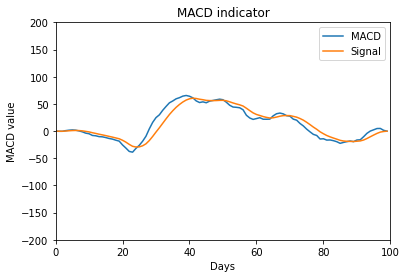

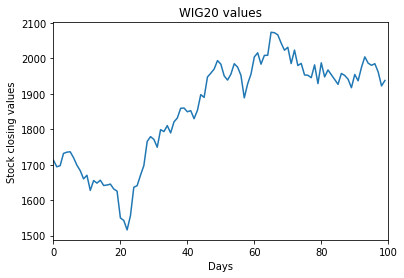

In [14]:
import pandas as pd
import numpy as np
from numpy import ndarray
from matplotlib import pyplot as plt
from pandas import DataFrame


URL = 'https://stooq.pl/q/d/l/?s=wig20&i=d'

SET_SIZE = 1000
X_LIMIT = [0, 0]
Y_LIMIT = [-200, 200]


def EMA(arr: ndarray, period: int, offset: int) -> float:
    """Returns EMA based on the close value, from last days
    specified by the period variable.
    Offset is counted from the current day.
    """
    a = 2 / (period + 1)
    upper_sum = 0.0
    lower_sum = 0.0

    for i in range(period + 1):
        if offset - i < 0:
            break
        upper_sum += arr[offset - i] * (1 - a) ** i
        lower_sum += (1 - a) ** i

    return upper_sum / lower_sum


def get_MACD(df: DataFrame) -> ndarray:
    MACD = []

    values = get_values(df)

    for i in range(values.size):
        MACD.append(EMA(values, 12, i) - EMA(values, 26, i))

    return np.asarray(MACD)


def get_signal(arr: ndarray) -> ndarray:
    signal = []

    for i in range(arr.size):
        signal.append(EMA(arr, period=9, offset=i))

    return np.asarray(signal)


def get_values(df: DataFrame) -> ndarray:
    val = df.to_numpy()
    val = val[:, 4]

    return val


def plot_values(df: DataFrame) -> None:
    val = get_values(df)

    x = [i for i in range(val.size)]

    plt.plot(x, val)
    plt.xlabel('Days')
    plt.ylabel('Stock closing values')
    plt.title('WIG20 values')
    axes = plt.gca()
    X_LIMIT[1] = len(x)
    axes.set_xlim(X_LIMIT)
    plt.show()


def plot_MACD(df: DataFrame) -> None:

    MACD = get_MACD(df)
    signal = get_signal(MACD)

    x = [i for i in range(MACD.size)]

    plt.plot(x, MACD, label='MACD')
    plt.plot(x, signal, label='Signal')
    plt.xlabel('Days')
    plt.ylabel('MACD value')
    plt.legend()
    plt.title('MACD indicator')
    axes = plt.gca()
    X_LIMIT[1] = len(x)
    axes.set_xlim(X_LIMIT)
    axes.set_ylim(Y_LIMIT)
    plt.show()


def simulate(df: DataFrame) -> None:
    resources = 1000
    volumes = 0

    MACD = get_MACD(df)
    values = get_values(df)
    signal = get_signal(MACD)

    buy = []
    sell = []

    for i in range(MACD.size):
        if MACD[i - 1] < signal[i - 1] and MACD[i] > signal[i]:
            buy.append(i)
        elif MACD[i - 1] > signal[i - 1] and MACD[i] < signal[i]:
            if len(buy) > 0:
                sell.append(i)

    # print(buy)
    # print(sell)
    # print(len(buy))
    # print(len(sell))
    # print(f'MACD = {MACD}')
    # print(f'len MACD = {MACD.size}')
    # print(f'values length = {values.size}')

    for i, value in enumerate(values):
        if i in buy:
            volumes = resources / value
            resources = 0
            buy.pop(0)
        elif i in sell:
            resources = value * volumes
            volumes = 0
            sell.pop(0)

            if not sell:
                break

    # print(f'Final resources = {resources}')


def main() -> None:
    df = pd.read_csv(URL)
    data_size = df.shape[0]
    print(data_size)
    df = df.tail(SET_SIZE)
    plot_MACD(df)
    plot_values(df)
    simulate(df)


if __name__ == '__main__':
    main()
